
#LGT1 Unit07 Day28 - In-Class Assignment: Deep Learning with Neural Networks
### <p style="text-align: right;"> &#9989; Put your name here.</p>

#### <p style="text-align: right;"> &#9989; Put your group member names here.</p>


## Goals of this assignment

The primary goal of this assignment is

* Learn about how computers perform image classification
* Learn about the famous MNIST machine-learning training data set
* Construct a simple convolutional neural networks
* Visualize and interpret a trained neural net

## Assignment instructions

Work with your group to complete this assignment. Upload the assignment to Gradescope at the end of class.
**Make sure everyone's name is listed in everyone's notebook before moving on**


# Part 1: MNIST Dataset
The MNIST database of handwritten digits, which is freely available, is a training set of 60,000 examples and a test set of 10,000 examples.
It is a subset of a larger set available from NIST.
The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.



## 1.1 Dataset characteristics
The MNIST database constists of $28\times 28$-pixel grayscale images of the 10 digits.
Sample images from MNIST test dataset:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" style="width: 500px;"/>

A computer sees an image as an array of numbers.
The matrix on the right contains numbers between 0 and 255, each of which corresponds to the pixel brightness in the left image.
Both are overlaid in the middle image.

<img src="https://user-images.githubusercontent.com/51207580/59979373-bc052480-9604-11e9-85b8-464367fdc891.png" style="width: 500px;"/>

## 1.2 Loading Modules and Data

In this exercise, we will use Google's [TensorFlow](https://www.tensorflow.org/) library, which is a free and open-source software library for machine learning and artificial intelligence.
It can be used for a range of tasks but has a particular focus on training and inference of deep neural networks (DNNs).
We will be using the Keras API of TensorFlow as well.

(Another popular free library is [PyTorch](https://pytorch.org/), which is also an open-source machine-learning framework.
It is based on the Torch library and is used for applications such as computer vision and natural-language processing, primarily developed by Facebook's AI Research lab.
We won't have time to cover this in this class.)

One useful feature of TensorFlow is its GPU acceleration.
The components of a DNN can be quite slow on CPU, but are well suited to GPU acceleration, since they mostly deal with many matrix operations.
The library uses optimized CUDA C++ code in libraries such as cuDNN to achieve greatly improved performance relative to CPU.

In [ ]:
# The OS module in Python provides functions for interacting with the operating system.
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # pick a first availiable GPU on this node

# Fix random seed
import numpy as np
from numpy.random import seed
seed(1)

# loading tensorflow and keras
import tensorflow as tf
tf.random.set_seed(2)
import tensorflow.keras as keras
keras.__version__

!nvidia-smi

Wed Mar 16 01:01:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We will load all the MNIST data using `tensorflow.keras.datasets.mnist.load_data`.

In [ ]:
# MNIST data is built into the tensorflow library; you only need to load this
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11501568/11490434 [==============================] - 0s 0us/step


In the code above, we divided the image data to into 60,000 and 10,000 images for the `train_` and `test_` data sets, respectively.
Training data is the data you use to set the parameters of your algorithm or machine-learning.
Test data is used to measure the performance of the trained model, such as its accuracy or efficiency.

In MNIST, each image has $28 \times 28$ pixels.
Since the images are black and while, so there will be only one channel.
(Color images typically have three channels: red, blue, green.)
We divide the image values by `255` to normalize them to between 0 and 1.

The function `to_categorical` converts the numbers, 0, 1, 2, ..., 9, into the one-hot-coded (basis) vectors in a 10-dimensional space:

\begin{align}
    0 \to \begin{bmatrix}
           1 \\
           0 \\
           0 \\
           \vdots \\
           0
         \end{bmatrix}, \hspace{1cm}
    1 \to \begin{bmatrix}
           0 \\
           1 \\
           0 \\
           \vdots \\
           0
         \end{bmatrix}, \hspace{1cm}
    2 \to \begin{bmatrix}
           0 \\
           0 \\
           1 \\
           \vdots \\
           0
         \end{bmatrix}, \qquad \ldots, \qquad
    9 \to \begin{bmatrix}
           0 \\
           0 \\
           0 \\
           \vdots \\
           1
         \end{bmatrix}
  \end{align}
  
`0` has 1 in the first element and 0 for the rest.
`1` has 0 in the first element, 1 in the scond, and 0 for the rest of the vector, and so on.
In this scheme, each category's vector is orthogonal.

At the end, if our CNN works, the output layer will return a vector in this space.
Each neuron in the final layer will giving a probability that the image corresponds to a certain digit.

## 1.3 Visualize a sample of training data
Now, we will pick a subset of training data to see what they look like.
All the training data are already being labeled with correct answers; these are the data you use to train the model so that it can make predictions, which we will test on the test data set.
In the code, we will print out the training data and its label to make sure everything is OK before moving on.

Training in this mode is called _supervised learning_, since we must tell the model the correct answers.
There are also methods for performing unsupervised learning, where the network must assign its own categories.

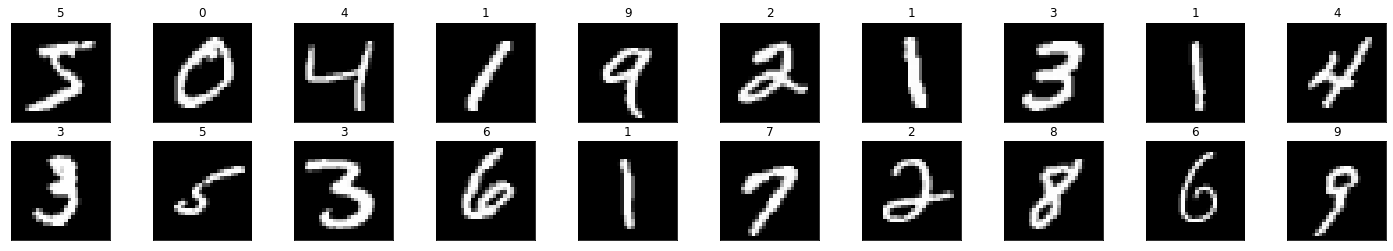

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
images, labels = train_images[:20], train_labels[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    ax.set_title(str(np.argmax(labels[idx])))

### 1.3.1 Examine an image in more detail
What does the neural network see?
Pick one of the training images and take a closer look.

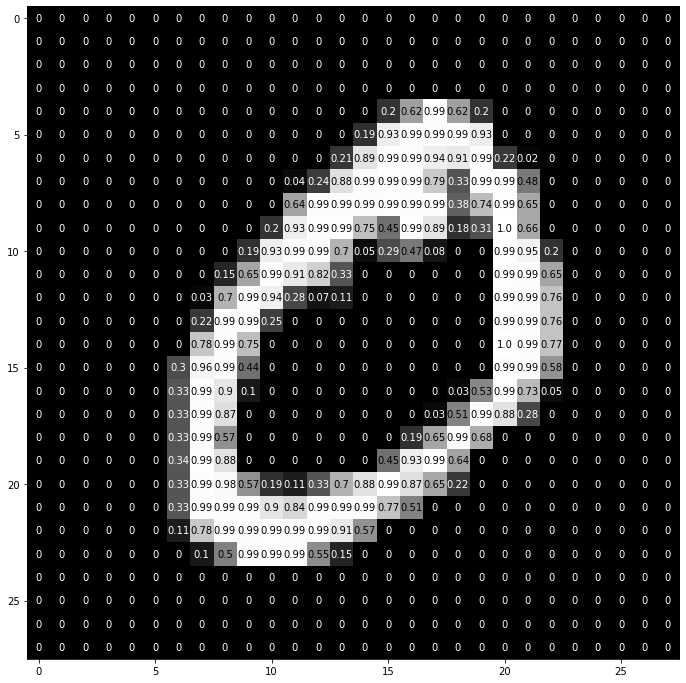

In [ ]:
img = np.squeeze(train_images[1])

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Part 2: Define the Network
The next step is to set up the neutral network.
A lot of the tools to build up the layers as shown in the figure earlier already pre-implemented in Keras.
All you need to do is to load them in and adjust some of the hyperparameters.

## 2.1 Your first model
We start to building the model using `models.Sequential`.
Our CNN looks like the following:
<img src="http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png" style="width: 600px;"/>
We use the `add` function to add a
`layers.Conv2D`, a 2D convolutional layer, for which you can specify its parameters:
1. Start with 32 $3 \times 3$ filters
1. Apply a nonlinear activation function to the output. Here we will be using [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).
1. For the **first** layer, you also need to specify the dimensionality of the input data. Recall we're using a $28 \times 28$-pixel image with 1 color channel. Once you specify the input for the first layer, Keras will be able to figure out the sizes of each of the subsequent layers based on your specifications.

For the second layer, we apply `MaxPooling2D`, which requires users to specify the size of the patches; here, we will use $2 \times 2$ patches.
Note that this layer doesn't have any parameters; it's deterministic.

Then, you can apply more convolutional and pooling layers as desired.

In [ ]:
# import layers and models
from tensorflow.keras import layers
from tensorflow.keras import models

# building your own model
model = models.Sequential()

# adding layer sequentially
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the network we've designed so far by using `summary`.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-traina

#### Task
Discuss the above output with your groupmates.
Does the output make sense?
Create a Markdown cell below and write down your group observations.

Put down your answer here

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Now, the network is complete.
Let's take a look at our model again.

In [ ]:
### your code here

#### Your observations here (focus on the new layers added since the previous discussion)


## 2.2 Compile and train
Now, let's train our CNN on the MNIST training set.
We will first import the `optimizers` module; in particular, we will be using `RMSprop` (root mean square propagation).
`RMSprop` and many other optimizers are different varieties of gradient descent.
RMSprop is given by:

\begin{align}
\ S_{dW} &= \beta_{S_{dW}} + (1 - \beta)\left(\frac{\partial{J}}{\partial{W}}\right)^2\\
\ W &= W - \alpha \frac{\frac{\partial{J}}{\partial{W}}}{\sqrt{S_{dW}}+ \epsilon}\\
\end{align}

where:

- $s$ is the exponentially weighted average of past squares of gradients
- $W$ is the weight tensor
- $\frac{\partial{J}}{\partial{W}}$ is the cost gradient with respect to current layer weight tensor
- $\beta$ is the _forgetting factor_ (a hyperparameter to be tuned)
- $\alpha$ is the learning rate
- $\epsilon$ is a very small constant to avoid dividing by zero

For `loss` function (see the previous machine-learning notebook)we choose `categorical_crossentropy`, which is a good loss function when you are classifying things into many categories.
For two categories, prefer `binary_crossentropy`; for real-ranged data (as opposed to classification), try `mean_absolute_error` or `mean_squared_error`.
It is important that the loss function is differentiable so that we can find all the derivatives.  

We can also specify some `metrics` to keep track of as we train the model.
We'll track the `'accuracy'` so we can tell how good our model is getting on the training data.

In [ ]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In deep learning, the landscape of the loss function is generally quite complex; we draw a simple landscape below for illustrative purposes, but recall we have hundreds of thousands of parameters, not two.
The loss function typically has lots of saddle points and local minima.
`RMSprop` helps to keep track of the gradients and avoid to get stuck with some initial local saddle points.
<img src="https://miro.medium.com/max/800/1*vpCRPR2o3tTl6R3JiRcvyQ.png" style="width: 300px;"/>





### 2.2.1 Aside concerning activation functions

In a neural network, the activation function is responsible for transforming the summed weighted input from the node into the activation of the node or output for that input.
Here, we discuss some of the activation functions commonly seen in DNN applications.

<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_deepLearning/images/activations.png?raw=true" alt="a few common activation functions" style="width: 500px;">

You can read more about these activations functions [here](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/).


#### ReLU (Rectified Linear Unit)

$$f(x) = \max(0, x)$$


The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive; otherwise, it will output zero.
It has become the default activation function for many types of neural networks, because a model that uses it is easier to train and often achieves better performance.

#### Softmax
The softmax function, also known as softargmax or normalized exponential function is

$$
p_i =  \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}   \quad  \text{for} \quad i \in [1,k].
$$

It is a generalization to multiple dimensions of the logistic function.

It is used in multinomial logistic regression and is often used as the last activation function of a neural network to normalize the output of a network to a probability distribution over predicted output classes, based on Luce's choice axiom.

### 2.2.2 Aside on loss functions

#### Categorical cross-entropy
A loss function widely used for evaluating multiclass classification, where an example can only belong to one out of many possible categories, and the model must decide which one.
Formally, it is designed to quantify the difference between two probability distributions.
It is given by:

$$ L = - \sum_i \log{p_i} $$

where $p_i$ is the predicted probability for the true class.
Notice that if all the predictions are correct with 100% confidence, $L=0$.

You can read more about optimizers and loss functions [here](http://cs231n.github.io/linear-classify/).
More examples of their use can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).

### 2.2.3 Training time!

The steps for training/learning from a batch of data are

1. Clear the gradients of all optimized variables
1. Forward pass: compute predicted outputs
1. Calculate the loss
1. Backward pass: compute gradient of the loss with respect to the model parameters
1. Update parameters
1. Update average training loss

Keras wraps up all of these steps in the function `fit`.
Like regression in Python, first you provide input data to the function; here they are `train_images`, `train_labels`.
You can set further options, including how many `epochs` you want to train it for, and a `batch_size` to specify how many images to evaluate per batch.
You may want to use a smaller batch size to fit inside the memory of your GPU, or use a larger batch size to use the GPU more efficiently.
Generally, models train faster per epoch with smaller batches, but larger batches run so much faster, they may train faster per wall-clock time.

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=256)

Epoch 1/5
235/235 [==============================] - 13s 15ms/step - loss: 1.1360 - accuracy: 0.7329
Epoch 2/5
235/235 [==============================] - 3s 14ms/step - loss: 0.3499 - accuracy: 0.8975
Epoch 3/5
235/235 [==============================] - 3s 14ms/step - loss: 0.2416 - accuracy: 0.9293
Epoch 4/5
235/235 [==============================] - 3s 14ms/step - loss: 0.1831 - accuracy: 0.9455
Epoch 5/5
235/235 [==============================] - 3s 14ms/step - loss: 0.1452 - accuracy: 0.9568


In the output, you should see the loss is going down and the accuracy is going up.
You should expect to get this model should be able to achieve better than 95% accuracy on the trainning set.
This is pretty good.

However, in the real world, one often would have to worry about the model overfitting to the training data.
In this case, the model can pick up some features that are only present in the trainning data but are not general features for all data.
To make sure that this does not happen, you should **always** reserve some data for testing; if the accurancy remains high in the test data, then you don't have an overfitting problem.

## 2.3 Test the trained network
Finally, we test our trained model on previously unseen test data to evaluate its performance.
Testing on unseen data is a good way to check that our model generalizes well.
It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

You can evaluate the model with test images and label quite easily by calling `evaluate` functions with the corresponding input data and labels.

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Test Accuracy: {:.4f} and Test Loss: {:.4f}'.format(test_acc, test_loss))

Test Accuracy: 0.9635 and Test Loss: 0.1184


#### 2.3.1 Task
Check out your results as well as your groupmates'.
Does anyone have overfitting issues?
Put down your observations
 in the cell below.

### 2.3.2 Monitor accuracy

Recall that you only trained the model for 5 epochs.
In principle, you can keep doing the training to improve the accuracy.
However, you need monitor the accuracy with respect to the test data.
If you start to see the accuracy in the test data descrease, you should stop; this is a sign of overfitting.

Lets look at the accurcy for all classes using `model.predict`.
If you find a specific class has lower accuracy, you can work to improve that, such as collecting more data for that particular class.

In [ ]:
# initialize lists to monitor test accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

pred = model.predict(test_images, verbose=0)
pred = np.argmax(pred, axis=-1)
labels = np.argmax(test_labels, axis=-1)

for i in range(len(pred)):
    correct = pred[i] == labels[i]
    class_correct[labels[i]] += correct
    class_total[labels[i]] += 1


for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 95% (983/1032)
Test Accuracy of     3: 97% (982/1010)
Test Accuracy of     4: 94% (928/982)
Test Accuracy of     5: 95% (849/892)
Test Accuracy of     6: 97% (933/958)
Test Accuracy of     7: 96% (987/1028)
Test Accuracy of     8: 91% (896/974)
Test Accuracy of     9: 97% (980/1009)

Test Accuracy (Overall): 96% (9635/10000)


Lets see predictions on individual test images. Since `model.predict` expects a batch of images, i.e, a 4-d tensor, we expand the first dimension of the test image before feeding into model.

Text(0.5, 1.0, 'Prediction: 7')

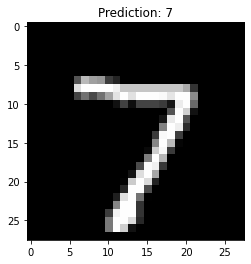

In [ ]:
index = 0
pred = np.argmax(model.predict(np.expand_dims(test_images[index], axis=0)))
plt.imshow(np.squeeze(test_images[index]), cmap='gray')
plt.title('Prediction: {}'.format(pred))

### 2.3.3 More Checks
You should also check examples of high-accurcy predictions.
These can be either very confident correct prediction or incorrect predictions.
Both cases can be interesting to investigate.
The following functions and codes will do these work.

In [ ]:
#Define a python generator
import itertools

def generator(images, labels, batch_size):
    iterable_1 = iter(images)
    iterable_2 = iter(labels)
    while True:
        l1 = tuple(itertools.islice(iterable_1, 0, batch_size))
        l2 = tuple(itertools.islice(iterable_2, 0, batch_size))
        if l1 and l2:
            yield np.vstack(np.expand_dims(l1, axis=0)), np.vstack(np.expand_dims(l2, axis=0))
        else:
            break

test_generator = generator(test_images, test_labels, 20)

#### Sample correct predictions

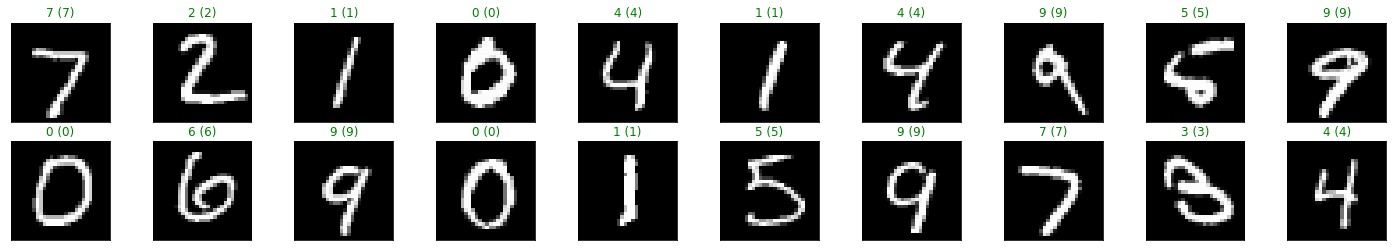

In [ ]:
images, labels = next(test_generator)
labels = np.argmax(labels, axis=-1)

# get sample outputs
preds = model.predict(images)
# convert output probabilities to predicted class
preds = np.argmax(preds, axis=-1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

#### Sample incorrect predictions

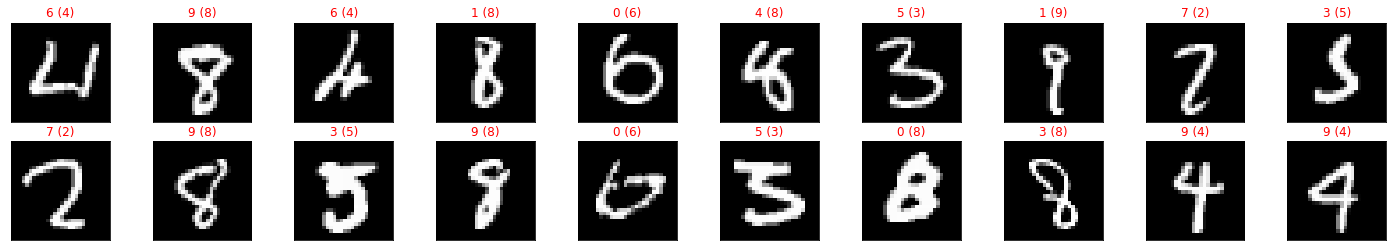

In [ ]:
# A sample of Incorrect Predictions
preds = np.argmax(model.predict(test_images), axis=-1)
labels = np.argmax(test_labels, axis=-1)
incorrect_idxs = np.where( preds != labels )[0]

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    idx = incorrect_idxs[i]
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

#### Task
Write down your observations of the correct and incorrect prediction outputs.

## 2.4 Interpret
So far we have used a number of functions to build up the layers without actually thinking much about what's happening in detail.
Even though we are getting good accuracy for the results, we so far have no idea what's going on inside the model.
This is generally the case for deep-learning networks.
Some techiniques, however, have been developed to try to understand what's happening inside the model.
We will take a look at a few such efforts.

### 2.4.1 Visualizing activiations of the next-to-last layer
<img src="https://web.archive.org/web/20230815174847if_/https://thumbs.gfycat.com/DeadlyDeafeningAtlanticblackgoby-size_restricted.gif" alt="Second Last Layer Activations" style="width: 400px;"/> (src: 3blue1brown)

The first thing you can do is to start to visualize the last few layers of models.
First we will define a new model, `emb_model` with specification of `inputs`  and `outputs` to `model.input` (`model` is the one that we have been builidng in this notebook) and `model.get_layer('dense').output` (this gives us the second last year of the dense network; you can also look at the last layer by using `dense_1` if you are intereted).

_Note: If you haven't executed the notebook exactly from top to bottom, the names of your layers may be different. Double-check their names using the `summary` function to make sure you're getting the right ones._

In [ ]:
from tensorflow.keras import Model

emb_model = Model(inputs = model.input, outputs = model.get_layer('dense').output)

Now let's look at what's inside the model by using `summary()` again:

In [ ]:
emb_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928 

Now we can pass the test images to this new model `emb_model` with `verbose=1` (so that we can see more outputs).
We will also collect `predictions` using `model.predict`.

In [ ]:
activations = emb_model.predict(test_images, verbose=1)
predictions = model.predict(test_images, verbose=1)
labels = predictions.argmax(axis=-1)

313/313 [==============================] - 1s 4ms/step


Let's check the shape of `activations`; it should give you `(10000,64)`. Why?

In [ ]:
activations.shape

(10000, 64)

Now, let's visualize the output.
With the following code, we will plot the neurons on the horizontal axis and a collection of digit examples on the vertical axis.
Thus, each row correpsonds to the activation pattern for a single image.

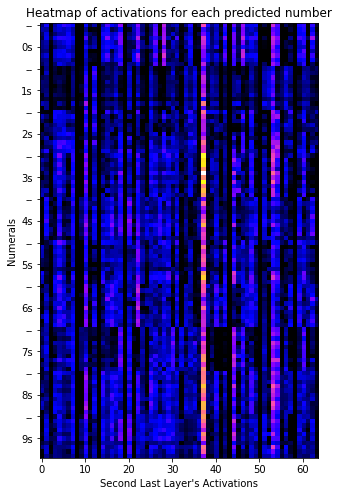

In [ ]:
# Stack 10 examples of activation vectors for each numeral
seq = []
for i in range(10):
    seq.append(activations[labels==i][:10])
seq = np.vstack(seq)


# Plot heatmap for the example activations
plt.figure(figsize=(8,8))
plt.imshow(seq, interpolation='nearest', cmap=plt.cm.gnuplot2)
plt.yticks(np.arange(0,100, 5), ['--','0s','--','1s','--','2s','--','3s','--','4s','--','5s','--','6s',
                                 '--','7s','--','8s','--','9s'])
plt.xlabel("Second Last Layer's Activations")
plt.ylabel('Numerals')
plt.title('Heatmap of activations for each predicted number')
plt.show()

Looking at each horizontal band corresponding to a kind of digit, you should see the activation pattern having a unique pattern. We can use a kind of clustering algothrim to transform the 64-dimensional vector into 3 or 2 dimensions.
Here, we are going to use an algorithm called [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) ($t$-distributed stochastic neighbor embedding), which is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two- or three-dimensional map.

We will first save the data:

In [ ]:
import io

with io.open('vecs.tsv', 'w', encoding='utf-8') as out_v:
    for embed in activations:
        out_v.write('\t'.join([str(x) for x in embed]) + "\n")

with io.open('meta.tsv', 'w', encoding='utf-8') as out_m:
    for l in labels:
        out_m.write(str(l) + "\n")

Now go to https://projector.tensorflow.org/, and in the data section click `Load`, and upload the two files, `vecs.tsv` and `meta.tsv`.

#### tSNE results

<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/2021Series/02_deepLearning/images/tSNE.png?raw=true" alt="tSNE" style="width: 400px;"/>

### 2.4.2 Visualizing intermediate-layer activations
You can also visualize intermediate-layer activations, which are mostly the convolutional layers.
There are a lot of layers, so we will pick a random test image and see how the activations work.

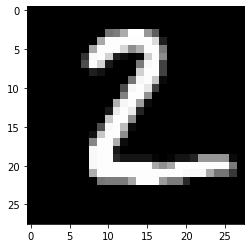

In [ ]:
img = test_images[1]
img = np.expand_dims(img, axis=0)

plt.imshow(np.squeeze(img), cmap='gray')

Again, we are creating a new model `activation_model` with `inputs` and `outputs`, and pass the selected image to `activation_model.predict`.

In [ ]:
from tensorflow.keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 8 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img)

You can see the first layer of activations by printing `activations[0]` or put more details of the substructure these 32  different filters.
Look at all the filters one by one, for example, with 6th and 12th filter `[0, :, :, 6]` or 12th layer `[0, :, :, 12]`.

In [ ]:
first_layer_activation = activations[0]

# double check the shape to make sure the layer structure match what you see in .summary()
print(first_layer_activation.shape)

(1, 26, 26, 32)


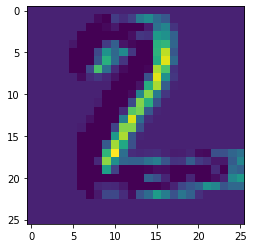

In [ ]:
plt.imshow(first_layer_activation[0, :, :, 6], cmap='viridis')
plt.show()

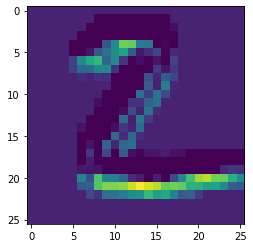

In [ ]:
plt.imshow(first_layer_activation[0, :, :, 12], cmap='viridis')
plt.show()

What do you observe from the above output?

`first_layer_activation[0, :, :, 6]` and  `first_layer_activation[0, :, :, 12]` seem to work like vertical and horizontal edge detectors with the highlighted portion in the output above.

Now pick another filter with your group and print them out to see what they do, and put down your observations.


In [ ]:
### your code here


#### What does your group observe?


You can go through all the layers and visualize them using the following code:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


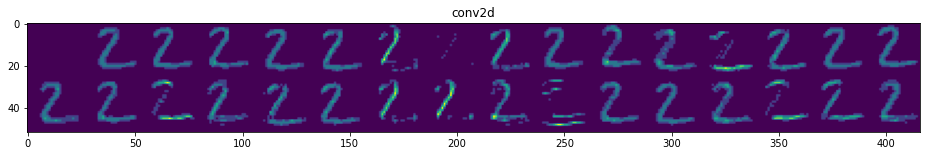

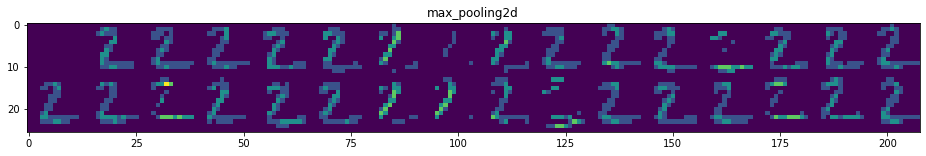

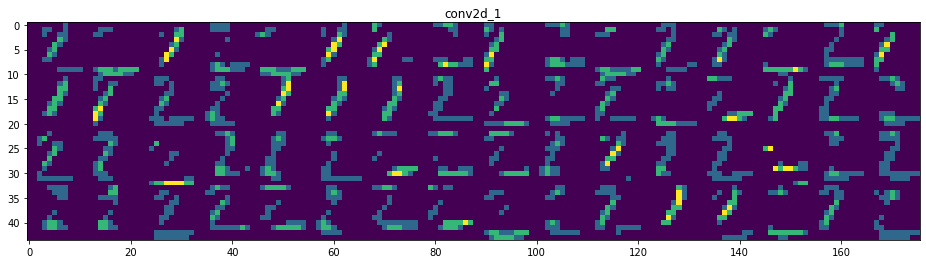

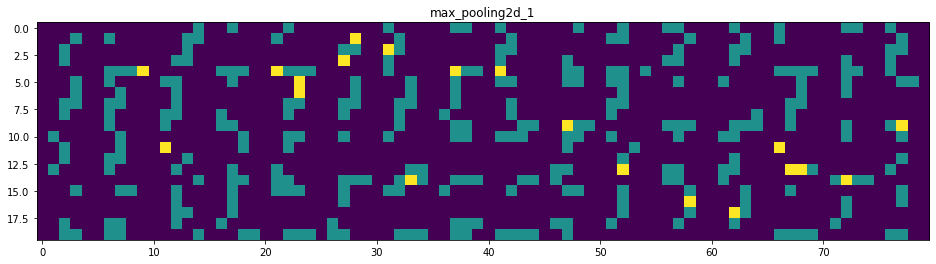

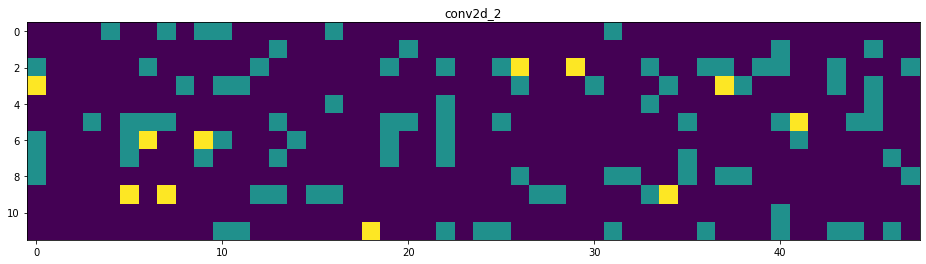

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            #channel_image *= 64
            #channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

#### Task
Discuss with your groupmates and put down your group's understanding of what's happening in these layers of the output.

Due to the limited time, we can't go through all the details.
If you are interested you, can learn more by reading the following literature:
1. [Visualizing and Understanding Convolutional Networks, Zeiler et. al.](https://arxiv.org/pdf/1311.2901.pdf)
1. [Visualizing intermediate activation in Convolutional Neural Networks with Keras](https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0)

### 2.4.3 Visualizing a heatmap of class activation

To visualize which parts of our image were the most prediction-like, let's set up the Grad-CAM process.

A _class activation map_ (CAM) is a visualization technique useful for understanding which parts of a given image led a CNN to its final classification decision by producing heatmaps of class activation over input images.





<img src="https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png" alt="MNIST CNN" style="width: 600px;"/>

The question is: if one changes the value of one of these filters, or one of the neurons of the filter, by a little bit, how much does the output change?

First, we pick an image, make the prediction, then take the gradient of the prediction with respect to neurons in the last convolution layer.
That gives you an idea of which neurons are important for this prediction.
We then map those neurons back to the input image to see what areas of the image the output is most sensitive to.

You can read more about this technique here:
- [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via Gradient-based Localization.](https://arxiv.org/abs/1610.02391)

You can find more examples [in Keras](https://keras.io/examples/vision/grad_cam/).

The following functions `make_gradcam_heatmap` and `get_superimposed_img` are taken from Keras.

In [ ]:
import tensorflow.keras.backend as K
import cv2

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def get_superimposed_img(img, heatmap):
    im = np.array(np.squeeze(img) * 255, dtype = np.uint8)
    cv2.imwrite('test_img.jpg', im)

    # We use cv2 to load the original image
    img = cv2.imread('test_img.jpg', 0)

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # 0.9 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.9 + img

    # Save the image to disk
    cv2.imwrite('test_img_cam.jpg', superimposed_img)

    cam = cv2.imread('test_img_cam.jpg', 0)
    return cam, heatmap

Let's take one of the images to see how this works.

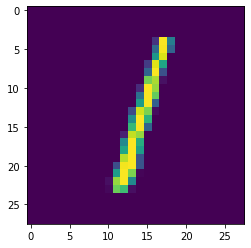

In [ ]:
img = test_images[2]
img = np.expand_dims(img, axis=0)
plt.imshow(np.squeeze(img))

First, we will take the last convolutional layer `conv2d_2` (from `model.summary()`).

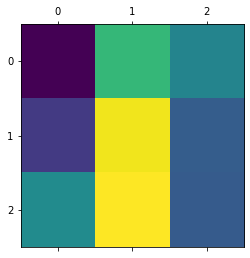

In [ ]:
last_conv_layer_name = "conv2d_2"

# Remove last layer's softmax
model.layers[-1].activation = None

# What the top predicted class is
preds = model.predict(img)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Find the gradient of your outputs with respect to this layer and then map back the receptive field of this layer onto the input image.


In [ ]:
cam, heatmap = get_superimposed_img(img, heatmap)

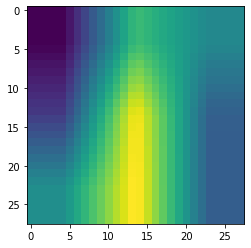

In [ ]:
plt.imshow(heatmap)

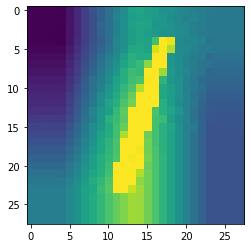

In [ ]:
plt.imshow(cam)

When the network predicted that this was a `1`, it was paying attention to the yellow (bright) region here.
So that just reaffirms that it was roughly looking at the right region of the image.

We can do this for a bunch of different images and see that the internal layers of the network are paying attention to the right patches of the input image when making decisions.

In [ ]:
cams, heatmaps = [], []

for i in range(280,291):

    img = test_images[i]
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

    cam, heatmap = get_superimposed_img(img, heatmap)

    cams.append(cam)
    heatmaps.append(heatmap)

The neural network is paying attention to roughly the right regions:

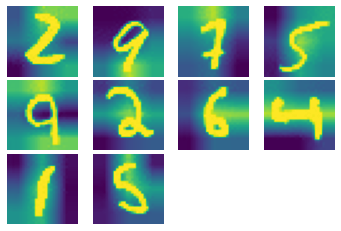

In [ ]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.axis('Off')
    plt.subplots_adjust(wspace=0.1,hspace=0.05)
    plt.imshow(cams[i])

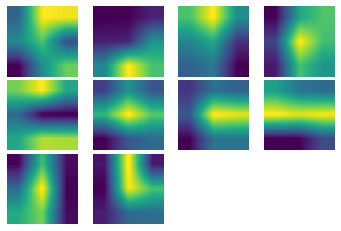

In [ ]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.axis('Off')
    plt.subplots_adjust(wspace=0.1,hspace=0.05)
    plt.imshow(heatmaps[i])

But since our neural network is very small and this is a toy data set, visualizations are not that great in identifying problems. Once you move to larger networks and train on millions of images, then Grad-CAM becomes very powerful.
If you go and look at the [Grad-CAM](https://arxiv.org/abs/1610.02391) paper, it shows some examples.  
Sometimes there can be some bias in the data set, and this visualization tool can show how the model can be biased by seeing where model is paying  attention.
Then, you can determine what action to take so that the model would work correctly.



# Part 3: Additional Deep-Learning Examples

We only showed a simple example in this class, but there are many fun examples one can do with deep learning.
Here are a few fun ones you can play around in your own time if you would like to do more deep learning.

1. [Google image classification](
https://developers.google.com/machine-learning/practica/image-classification): the classcial Cats vs Dongs classification


1. [NeMo Voice Swap](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb): Use Nvidia's NeMo conversational AI Toolkit to swap a voice in an audio fragment with a computer generated one.

1. [Text Classification](https://www.tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either positive or negative.

1. [Style Transfer](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.

1. [Multilingual Universal Sentence Encoder Q&A](https://www.tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.

1. [Retraining an Image Classifier](https://www.tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.